# Assignment 1: ODrive setup and initial kinematics exploration

In homework 1 we will learn the basic functionality of the ODrive motor controller and the kinematics of the 5-bar leg. There are 5 problems below. You will turn this assignment in by uploading it to your own github repository for this assignment and then sending a link to ngravish@eng.ucsd.edu with the subject MAE_207_HW1. The assignment is to be completed in pairs, one per team.

If you would like, you directly ```fork``` this repository into your github account, this is found in the upper right hand corner. You can then download the repository to your computer using the ```clone``` button on the right side. Once you are done with the assignment, commit the changes back to the github online repository. 

Alternatively you can just download the .ipynb file, edit it as you solve the problems, and then in the end upload to a github repo.

Team #: 3

Names: Rahul Shirpurkar , Qichao Zheng



## Problem 1: Familiarization with ODrive firmware

__1.1__ You should follow the instructions to flash the motor controller firmware found [here](https://github.com/madcowswe/ODrive).

__1.2__ In the ```Odrive/Firmware/MotorControl``` folder are the code files that control the motor. The most important file is ```low_level.c```. Find this file and familiarize yourself with it. 

__1.3__ In ```low_level.c``` the main function for motor control is ```control_motor_loop(Motor_t* motor)```. Find this function and copy and paste blocks of it into the cell below.  Annotate the function step-by-step in simple language the operations it performs. (*I have started this annotation*). Use the three backticks \`\`\` and the letter c for the c language to highlight each code block.






```c
void control_motor_loop(Motor_t* motor) {
    while (*(motor->axis_legacy.enable_control)) {
        if (osSignalWait(M_SIGNAL_PH_CURRENT_MEAS, PH_CURRENT_MEAS_TIMEOUT).status != osEventSignal) {
            motor->error = ERROR_FOC_MEASUREMENT_TIMEOUT;
            break;
        }

        if (!do_checks(motor))
            break;
        if (!loop_updates(motor))
            break;
```
While motor axis is set to enable_control flag/setting do all the following,<br><br>
check if the status of osSignalWait function is not the expected value (= returned by osEventSignal), set motor error flag and break execution <br>
if motor check and loop update functions return errors, break the program execution
<br>
<br>


        
```c    
        // Position control
        float vel_des = motor->vel_setpoint;
        if (motor->control_mode >= CTRL_MODE_POSITION_CONTROL) {
            if (motor->rotor_mode == ROTOR_MODE_SENSORLESS) {
                motor->error = ERROR_POS_CTRL_DURING_SENSORLESS;
                break;
            }
            float pos_err = motor->pos_setpoint - motor->encoder.pll_pos;
            vel_des += motor->pos_gain * pos_err;
        }
```
For position control of the motor, a variable called "vel_des" (design velocity?) is initiated with the value returned by/saved under "vel_setpoint" in the configuration<br>
check if the motor control mode is "position control" and if the rotor mode is "sensorless", set error flag with appropriate value and break execution of program<br>
else set position error as the diffference between the ideal motor position returned by reading "pos_setpoint" and the current position returned by the encoder<br>
update "vel_des" using formula
<br><br>

```c
        // Velocity limiting
        float vel_lim = motor->vel_limit;
        if (vel_des > vel_lim) vel_des = vel_lim;
        if (vel_des < -vel_lim) vel_des = -vel_lim;
```
For the velocity limited mode, set "vel_lim" equal to value returned by reading the limit saved under "vel_limit" in the configuration<br>
if design velocity is greater than the limit, lower the design velocity to limit value<br>
if it is less than the negative value of the limit, raise it to the negative value of the limit<br><br>

```c
        // Velocity control
        float Iq = motor->current_setpoint;

        // Anti-cogging is enabled after calibration
        // We get the current position and apply a current feed-forward
        // ensuring that we handle negative encoder positions properly (-1 == motor->encoder.encoder_cpr - 1)
        if (motor->anticogging.use_anticogging) {
            Iq += motor->anticogging.cogging_map[mod(motor->encoder.pll_pos, motor->encoder.encoder_cpr)];
        }

        float v_err = vel_des - get_pll_vel(motor);
        if (motor->control_mode >= CTRL_MODE_VELOCITY_CONTROL) {
            Iq += motor->vel_gain * v_err;
        }
```
Set the value of variable "Iq" equal to the value returned by the "current_setpoint" entity<br>
if the motor is in "anti-cogging" mode, update Iq with the value returned by the cogging-map<br>
set v_error (velocity error) equal to the difference between the design velocity and the current velocity read using the "get_pll_vel" function<br>
if velocity control mode is being used, update the value of Iq using the formula<br><br>

```c
        // Velocity integral action before limiting
        Iq += motor->vel_integrator_current;

        // Apply motor direction correction
        if (motor->rotor_mode == ROTOR_MODE_ENCODER ||
            motor->rotor_mode == ROTOR_MODE_RUN_ENCODER_TEST_SENSORLESS) {
            Iq *= motor->encoder.motor_dir;
        }
```
Update the value of Iq by adding the vale of the velocity integrator current saved in the configuration<br>
if the motor is being run by being controlled by encoder signals or is being tested in sensorless mode, apply the motor direction correction to Iq using the formula<br><br>

```c
        // Current limiting
        float Ilim = MACRO_MIN(motor->current_control.current_lim, motor->current_control.max_allowed_current);
        bool limited = false;
        if (Iq > Ilim) {
            limited = true;
            Iq = Ilim;
        }
        if (Iq < -Ilim) {
            limited = true;
            Iq = -Ilim;
        }
```
For the current limited mode, the value of variable Ilim (Current limit) is set equal to the minimum of the saved current limit value (in configuration) and the saved value of max allowable current<br>
if the current value of the electric current is greater than the value given to Ilim, reduce it to Ilim value and set the value of boolean type variable to "True"<br>
if its value is less than the negative of Ilim, increase it to that value and set "limited" equal to "True"<br><br>

```c
        // Velocity integrator (behaviour dependent on limiting)
        if (motor->control_mode < CTRL_MODE_VELOCITY_CONTROL) {
            // reset integral if not in use
            motor->vel_integrator_current = 0.0f;
        } else {
            if (limited) {
                // TODO make decayfactor configurable
                motor->vel_integrator_current *= 0.99f;
            } else {
                motor->vel_integrator_current += (motor->vel_integrator_gain * current_meas_period) * v_err;
            }
        }
```
if the control mode is not velocity control, reset the value of velocity integrator current to zero<br>
else if it is being run using current limiting (under velocity control mode) , set its value to 99% of its old value<br>
if not current limiting mode (under velocity control mode), set the integrator value to new value using formula<br><br>


```c
        // Execute current command
        if (motor->motor_type == MOTOR_TYPE_HIGH_CURRENT) {
            if(!FOC_current(motor, 0.0f, Iq)){
                break; // in case of error exit loop, motor->error has been set by FOC_current
            }
        } else if (motor->motor_type == MOTOR_TYPE_GIMBAL) {
            //In gimbal motor mode, current is reinterptreted as voltage.
            if(!FOC_voltage(motor, 0.0f, Iq)){
                break; // in case of error exit loop, motor->error has been set by FOC_voltage
            }
        } else {
            motor->error = ERROR_NOT_IMPLEMENTED_MOTOR_TYPE;
            break;
        }

        ++(motor->loop_counter);
```
if the motor is being run in high current input mode and the value of current is higher than that determined by Iq, stop execution and give error<br>
if in gimbal mode, and velocity is not within limits, stop execution and give error<br>
else if mode not specified, exit and give appropriate error<br><br>

```c
    }
```
end of while loop<br>
```c
    //We are exiting control, reset Ibus, and update brake current
    motor->current_control.Ibus = 0.0f;
    update_brake_current();

}
```
End of sub-routine<br><br>

## Problem 2: Connecting to ODrive through the python library

__2.1__ The ODrive provides a python library called ```odrive``` in the ```/ODrive/Tools/``` directory. A python library consists of a folder (```odrive``` in this case) which contains python files and a file called ```__init__.py```. Find this library.

__2.2__ Test that you can import the ```odrive``` library and other required libraries into Python by running the code below (shift-enter when the cell is selected). You may need to move your Copy the ```odrive``` folder to the same folder as this notebook, or move this notebook to the same directory as ```odrive```. 



In [12]:
import odrive.core
import time
import math

import numpy as np
import matplotlib.pyplot as plt

from IPython.lib.display import YouTubeVideo # for youtube videos

# This may be qt4 depending on your python environment
%matplotlib qt5


__2.3__ Run the code below to connect to the odrive motor controller. If this executes successfully you will be able to access the motor controller functions through the ```my_drive``` variable.

In [337]:
my_drive = odrive.core.find_any(consider_usb=True, consider_serial=False, printer=print)

# define handles to the motor functions
m0=my_drive.motor0
m1=my_drive.motor1 


looking for ODrive...
Found ODrive via PyUSB
ConfigurationValue 1
	InterfaceNumber 0,0
		EndpointAddress 130
	InterfaceNumber 1,1
		EndpointAddress 1
		EndpointAddress 129

EndpointAddress for writing 1

EndpointAddress for reading 129

Connecting to device on USB device bus 0 device 20
JSON: [{"name":"","id":0,"type":"json","access":"rw"},{"name":"vbus_voltage","id":1,"type":"float","access":"r"},{"name":"serial_number","id":2,"type":"uint64","access":"r"},{"name":"run_anticogging_calibration","id":3,"type":"function","arguments":[]},{"name":"config","id":5,"type":"object","members":[{"name":"brake_resistance","id":6,"type":"float","access":"rw"}]},{"name":"axis0","id":8,"type":"object","members":[{"name":"config","id":9,"type":"object","members":[{"name":"enable_control_at_start","id":10,"type":"bool","access":"rw"},{"name":"do_calibration_at_start","id":11,"type":"bool","access":"rw"}]}]},{"name":"motor0","id":14,"type":"object","members":[{"name":"config","id":15,"type":"object","m

## Problem 3: Exploring and interacting with the ODrive

__3.1__ Write a function to call read the encoder position and velocity estimates and return them. As a start, the encoder position for motor 0 can be read using the ```m0.encoder.pll_pos,m1.encoder.pll_pos``` command. 

In [338]:
# in python we can define a function using the def command. The function definition code is indicated by tab indented code. When the 
# tab indentation stops the function definition has stopped. As shown below we can define a function and then call it immediately after
def get_encoder_state():
    
    motor0_position = m0.encoder.pll_pos
    motor1_position = m1.encoder.pll_pos
    motor0_velocity = m0.encoder.pll_vel
    motor1_velocity = m1.encoder.pll_vel
    
    return (motor0_position, motor0_velocity, motor1_position, motor1_velocity)
    
    
# We can now call this function in the same code block
state = get_encoder_state()
print(state)


(0.19764643907546997, -0.0135345458984375, -0.7858702540397644, -0.0015716552734375)


__3.2__ The motor encoder returns absolute position measurements that are zerod on the position the motor was in during startup. It is useful to define new motor origins for the left and righ motor. Extend the legs so that they are straight and then read the encoder positions to the tuple variable 

```home_position = (motor0_home, motor1_home)```

A tuple is like an array, it can contain sequences of objects (numbers, strings, etc.), but it cannot be changed after it is written so it is perfect for storing unchangeable data like the home location.

In [230]:
#Check values before changing for record keeping

m0vgain = m0.config.vel_gain
m1vgain = m1.config.vel_gain
m0pgain = m0.config.pos_gain
m1pgain = m1.config.pos_gain
m0int = m0.config.vel_integrator_gain 
m1int = m1.config.vel_integrator_gain


print(m0vgain,m1vgain)
print(m0pgain,m1pgain)
print(m0int,m1int)

0.0005000000237487257 0.0005000000237487257
20.0 20.0
0.0010000000474974513 0.0010000000474974513


In [ ]:
#To make motors turn with external force without any resistance 
m0.config.pos_gain = 0
m0.config.vel_integrator_gain = 0

m1.config.pos_gain = 0
m1.config.vel_integrator_gain = 0


In [388]:
motor0_home = m0.encoder.pll_pos
motor1_home = m1.encoder.pll_pos

home_position = (motor0_home,motor1_home)
print(home_position)

(-0.2294202744960785, -1.344172716140747)


In [331]:
#Reset back to default values: Loosen legs before running!!


m0.config.pos_gain = m0pgain
m0.config.vel_integrator_gain = m0int

m1.config.pos_gain = m1pgain
m1.config.vel_integrator_gain = m1int

__3.3__ The motor move commands will move them to absolute positions with respect to the encoder zero position, this may not be the same as the ```home_position``` that we defined above. Write a function to move the motors to an absolute position relative to the ```home_position```. For reference we can move a motor with the ```set_pos_setpoint(pos_setpoint, vel_feed_forward, current_feed_forward)``` command. We don't need the feedforward terms in this problem.

In [309]:
def move_motors(motor1_new_position, motor2_new_position):
    m0.set_pos_setpoint(motor1_new_position + home_position[0], 0, 0)
    m1.set_pos_setpoint(motor2_new_position + home_position[1], 0, 0)
    

#Calling function
state = get_encoder_state()
print("Position before rotation is: (",state[0],",",state[2],")") 

move_motors(100, 100) # note make the intial move distance small!!

time.sleep(0.75)
state = get_encoder_state()
print("Position after rotation is: (",state[0],",",state[2],")") 

Position before rotation is: ( 54943.9765625 , 54942.76171875 )
Position after rotation is: ( 55029.76953125 , 55029.76171875 )


In [389]:
#return home:
def go_home():
    m0.set_pos_setpoint(home_position[0], 0, 0)
    m1.set_pos_setpoint(home_position[1], 0, 0)
    
    
#Calling function  
state = get_encoder_state()
print("Position before rotation is: (",state[0],",",state[2],")") 

go_home()

time.sleep(0.75)
state = get_encoder_state()
print("Position after rotation is: (",state[0],",",state[2],")")
print("home is:",home_position)

Position before rotation is: ( 0.23584401607513428 , -1.1513874530792236 )
Position after rotation is: ( -2.765634059906006 , -1.1126630306243896 )
home is: (-0.2294202744960785, -1.344172716140747)


## Problem 4: Determine the workspace of the robot leg

__4.1__ The end of the robot leg has a hole in it. Place a pen in the hole, place a paper below the robot and trace out the boundary of the robot leg's workspace by hand. Make sure to note where the edge of the aluminum frame is. Take a picture of the workspace tracing (keep your robot in place) and attach it to you this notebook. You can attach images by putting them in the same directory and then writing ```![Image description](filename.extension)```  

__4.2__ Now repeat the measurement of the leg workspace while recording the encoder position (*relative to your new home*) in a loop. This is a measurement configuration space of the robot which is two dimensional ($\theta_0$, $\theta_1$), and bounded by the leg range of motion. Make a plot of the configuration space boundaries by plotting your measured positions as ```xy``` coordinates ($\theta_0$, $\theta_1$). Include two plots below, the first is the configuration space using encoder units, the second is scaled to $-\pi,\pi$. You will have to determined the calibration constant (note the encoder generates 2048\*4 counts per revolution).

In [314]:
#To make motors turn with external force without any resistance 
m0.config.pos_gain = 0
m0.config.vel_integrator_gain = 0

m1.config.pos_gain = 0
m1.config.vel_integrator_gain = 0

In [330]:
# Setup an array to store the encoder positions
left_motor = [] # initialize a empty list. You can add to a list with the left_motor.append(item) command
right_motor = [] # initialize an empty list

calibration=2048*4/(2*math.pi)

for i in range(30):
        left_motor.append(m1.encoder.pll_pos - home_position[1] )
        right_motor.append(m0.encoder.pll_pos - home_position[0] )
        time.sleep(0.5)
current_time = time.monotonic()


    
# Plot the results using encoder values (centered on your new home) and scaled to be between -pi, pi
plt.subplot(1,2,1)
plt.plot(left_motor, right_motor)
plt.xlabel('Left')
plt.ylabel('Right')

plt.subplot(1,2,2)
plt.plot([c/calibration for c in left_motor], [c/calibration for c in right_motor])
#plt.plot(left_motor / calibration, right_motor / calibration)
plt.xlabel('Left')
plt.ylabel('Right')



Text(0,0.5,'Right')

![Workspace Photo](photo1.jpg)

![Workspace_plot](Figure_1.png)

## Problem 5: Command a simple cyclic gait of the leg

__5.1__ In this last problem we will command a simple cyclic gait of the leg by sending sinusoidal position commands to the motors and exploring how phase and amplitude differences influence the foot motion. Record the encoder position while running the gait and provide plots of the motor angles as a function of time. Additionally, take a video of each gait and post it to youtube, including a link in the notebook at the very bottom. You can include youtube videos by entering the command ```YouTubeVideo('video_code')``` in a code cell, where video code is found from the youtube page.

*Provide plots and videos for three different gaits*


## Gait 1:

In [481]:
#Left = Motor1, Right = Motor0
a_l = 900 #Amplitude_left 
a_r = 900 #Amplitude_right
p_l= 0 #Phase_left 
p_r = math.pi/2 #Phase_right
w_l = 5 #omega
w_r = 5

initial_time = time.monotonic()# record the current time
t0 = initial_time
current_time = time.monotonic()

l_pos = []
r_pos = []
t = []

while (current_time - t0) < 10:
    current_time = time.monotonic()
    l_new = -a_l*math.sin(w_l*(current_time - t0) + p_l)
    r_new = -a_r*math.sin(w_r*(current_time - t0) + p_r)
    move_motors(r_new, l_new)      ##Motor 0 = right , Motor 1 = left !!
    l_pos.append(m1.encoder.pll_pos - home_position[1] )
    r_pos.append(m0.encoder.pll_pos - home_position[0] )
    t.append(current_time - t0)
    time.sleep(0.005)
    

plt.plot(t, l_pos, label = 'Left Motor (m1)')
plt.xlabel('Time (sec)')
plt.ylabel('Motor Positon')
plt.plot(t, r_pos, label = 'Right Motor (m0)')
plt.legend(loc='upper right')
  

go_home()

![Gait 1](gait1.png)

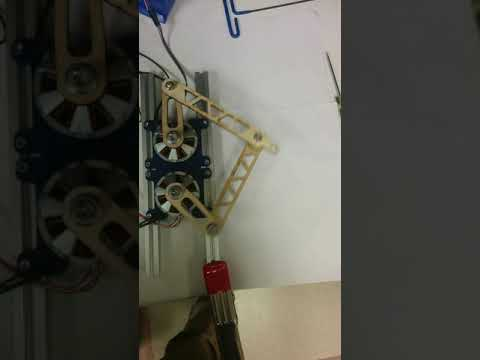

In [15]:
YouTubeVideo('tYjjI4jPLn4')

## Gait 2:

In [482]:
#Left = Motor1, Right = Motor0
a_l = 1200 #Amplitude_left 
a_r = 900 #Amplitude_right
p_l = 5*math.pi/6  #Phase_left 
p_r = math.pi/2 #Phase_right
w_l = 5 #omega
w_r = 5

initial_time = time.monotonic()# record the current time
t0 = initial_time
current_time = time.monotonic()

l_pos = []
r_pos = []
t = []

while (current_time - t0) < 10:
    current_time = time.monotonic()
    l_new = -a_l*math.sin(w_l*(current_time - t0) + p_l)
    r_new = -a_r*math.sin(w_r*(current_time - t0) + p_r)
    move_motors(r_new, l_new)      ##Motor 0 = right , Motor 1 = left !!
    l_pos.append(m1.encoder.pll_pos - home_position[1] )
    r_pos.append(m0.encoder.pll_pos - home_position[0] )
    t.append(current_time - t0)
    time.sleep(0.005)
    
plt.plot(t, l_pos, label = 'Left Motor (m1)')
plt.xlabel('Time (sec)')
plt.ylabel('Motor Positon')
plt.plot(t, r_pos, label = 'Right Motor (m0)')
plt.legend(loc='upper right')    

go_home()

![Gait 2](gait 2.png)

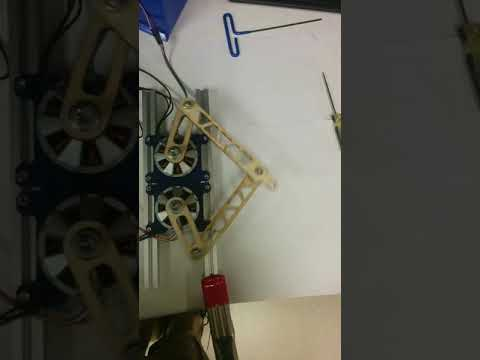

In [16]:
YouTubeVideo('mWPRoiirISo')

## Gait 3:

In [483]:
#Left = Motor1, Right = Motor0
a_l = 1500 #Amplitude_left 
a_r = 500 #Amplitude_right
p_l= math.pi/3 #Phase_left 
p_r = 0 #Phase_right
w_l = 5 #omega
w_r = 10

initial_time = time.monotonic()# record the current time
t0 = initial_time
current_time = time.monotonic()

l_pos = []
r_pos = []
t = []

while (current_time - t0) < 10:
    current_time = time.monotonic()
    l_new = -a_l*math.sin(w_l*(current_time - t0) + p_l)
    r_new = -a_r*math.sin(w_r*(current_time - t0) + p_r)
    move_motors(r_new, l_new)      ##Motor 0 = right , Motor 1 = left !!
    l_pos.append(m1.encoder.pll_pos - home_position[1] )
    r_pos.append(m0.encoder.pll_pos - home_position[0] )
    t.append(current_time - t0)
    time.sleep(0.005)
    
plt.plot(t, l_pos, label = 'Left Motor (m1)')
plt.xlabel('Time (sec)')
plt.ylabel('Motor Positon')
plt.plot(t, r_pos, label = 'Right Motor (m0)')
plt.legend(loc='upper right')  

go_home()

![Gait 3](gait 3.png)

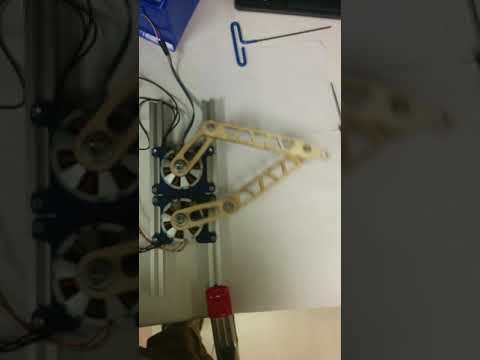

In [17]:
YouTubeVideo('UGwiV4xps2w')